In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

from fim import apriori as fim_apriori
from gsp import apriori as gsp_apriori

# Task 4: Frequent Pattern mining and Association Rule Mining

In [2]:
df_geo = pd.read_csv('../geography.csv', sep=',', index_col=0)
df_ram = pd.read_csv('../ram.csv', sep=',', index_col=0)

# Processed dataset split for VCS purposes
df_sales_part1 = pd.read_csv('../DM_14_TASK1/task1-df_sales-part1.csv', sep=',', index_col=0) #The dataset doesn't have a column name. This causes the error.
df_sales_part2 = pd.read_csv('../DM_14_TASK1/task1-df_sales-part2.csv', sep=',', index_col=0)
df_sales = df_sales_part1.append(df_sales_part2)

df_time = pd.read_csv('../time.csv', sep=',', index_col=0)
df_vendor = pd.read_csv('../vendor.csv', sep=',', index_col=0)

/home/avenger/.local/lib/python3.9/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
#Merge data into a single dataframe
df_sales_merged = df_sales[["Id", "ram_code"]].join(df_ram, on="ram_code", rsuffix="_ram")
df_sales_merged["time_code"] = df_sales["time_code"]
df_sales_merged = df_sales_merged.join(df_time.set_index("time_code"), on="time_code")
df_sales_merged["geo_code"] = df_sales["geo_code"]
df_sales_merged = df_sales_merged.join(df_geo.set_index("geo_code"), on="geo_code")
df_sales_merged["vendor_code"] = df_sales["vendor_code"]
df_sales_merged = df_sales_merged.join(df_vendor.set_index("vendor_code"), on="vendor_code", rsuffix="_vendor")
df_sales_merged = df_sales_merged.join(df_sales[["sales_uds", "sales_currency"]])

#Make the ram_code feature a string in order to use it with gsp
df_sales_merged.loc[:, "ram_code"] = df_sales_merged.loc[:, "ram_code"].astype(int).apply(str)

In [4]:
df_sales_merged.head()

Id ram_code  brand   name  memory memory_type  clock  time_code  \
2602347  3719        1  ADATA  Adata     0.5         DDR    400   20130322   
2602348  3719        1  ADATA  Adata     0.5         DDR    400   20130323   
2602349  3719        1  ADATA  Adata     0.5         DDR    400   20130326   
2602350  3719        1  ADATA  Adata     0.5         DDR    400   20130327   
2602351  3719        1  ADATA  Adata     0.5         DDR    400   20130328   

         year  month  ...  week  geo_code  continent  country  \
2602347  2013      3  ...    12        25     Europe  Germany   
2602348  2013      3  ...    12        18     Europe  Germany   
2602349  2013      3  ...    13        28     Europe  Germany   
2602350  2013      3  ...    13        25     Europe  Germany   
2602351  2013      3  ...    13        27     Europe  Germany   

                         region currency vendor_code       name_vendor  \
2602347  north rhine-westphalla      EUR          32  geizhals_unknown   
2602348                  berlin      EUR          32  geizhals_unknown   
2602349                  saxony      EUR          32  geizhals_unknown   
2602350  north rhine-westphalla      EUR          32  geizhals_unknown   
2602351                saarland      EUR          32  geizhals_unknown   

         sales_uds  sales_currency  
2602347  13.749032           10.65  
2602348  13.828708           10.65  
2602349  13.694297           10.65  
2602350  13.690530           10.65  
2602351  13.605216           10.65  

[5 rows x 21 columns]

## Dataframe pre-processing  
Here we are interested in making the sales dataframe more suitable for our analyses.

### Feature removal

In [5]:
feat_to_drop = ["Id", "time_code", "geo_code", "vendor_code", "sales_currency"]

df_sales_proc = df_sales_merged.drop(feat_to_drop, axis=1)
df_sales_proc.head()

ram_code  brand   name  memory memory_type  clock  year  month  day  \
2602347        1  ADATA  Adata     0.5         DDR    400  2013      3   22   
2602348        1  ADATA  Adata     0.5         DDR    400  2013      3   23   
2602349        1  ADATA  Adata     0.5         DDR    400  2013      3   26   
2602350        1  ADATA  Adata     0.5         DDR    400  2013      3   27   
2602351        1  ADATA  Adata     0.5         DDR    400  2013      3   28   

         week continent  country                  region currency  \
2602347    12    Europe  Germany  north rhine-westphalla      EUR   
2602348    12    Europe  Germany                  berlin      EUR   
2602349    13    Europe  Germany                  saxony      EUR   
2602350    13    Europe  Germany  north rhine-westphalla      EUR   
2602351    13    Europe  Germany                saarland      EUR   

              name_vendor  sales_uds  
2602347  geizhals_unknown  13.749032  
2602348  geizhals_unknown  13.828708  
2602349  geizhals_unknown  13.694297  
2602350  geizhals_unknown  13.690530  
2602351  geizhals_unknown  13.605216

Here we removed some features that are either redundant or do not carry useful information for this task.

### Feature discretisation
We are interested in discretising memory, clock and the sales value using equal-width binning.

#### Memory

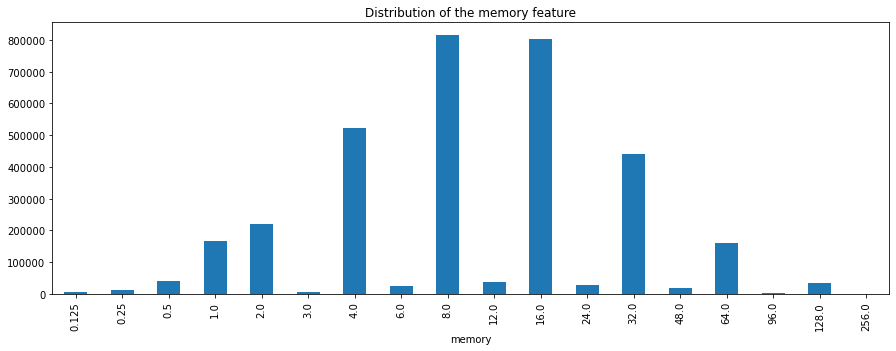

In [6]:
plt.figure(figsize=(15,5))
plt.title("Distribution of the memory feature")
df_sales_proc.groupby("memory").size().plot(kind="bar")
plt.show()

The distribution of memory has an almost symmetric distribution, we can use this to define different bins.  
We will consider the ranges [0,4], [6,8], [12,16], [24,32] and [48,256].  

This choice is in part due to the distribution above and in part based on our knowledge of sizes of ram found in the commercial products.  
In low cost/power/old products usually the amount of ram doesn't exceed 4 GB, mid-range can go up to 8 GB and so on.  
Regarding the last range it reflects the fact that amount of memory is usually used for servers/high-end workstations, therefore they belong to a class of their own.

In [7]:
bins = pd.IntervalIndex.from_tuples([(0, 4), (6, 8), (12, 16), (24, 32), (48, 256)], closed="both")

df_sales_proc.loc[:, "memory"] = pd.cut(df_sales_proc['memory'].astype(int), bins, right=False)
df_sales_proc.loc[:, "memory"] = df_sales_proc["memory"].astype(str) + '_mem'

#### Clock

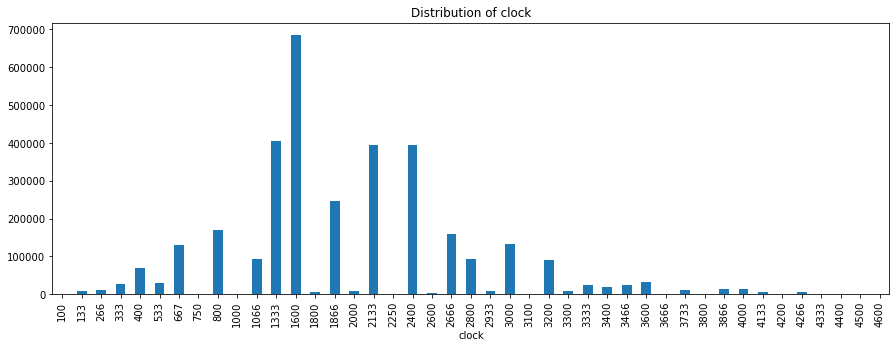

In [8]:
plt.figure(figsize=(15,5))
plt.title("Distribution of clock")
df_sales_proc.groupby(["clock"]).size().plot(kind="bar")
plt.show()

In [9]:
bins = pd.IntervalIndex.from_tuples([(100, 1333), (1600, 1800), (1866, 2250), (2400, 3200), (3300, 4600)], closed="both")

df_sales_proc.loc[:, "clock"] = pd.cut(df_sales_proc['clock'].astype(int), bins, right=False)
df_sales_proc.loc[:, "clock"] = df_sales_proc["clock"].astype(str) + '_clock'

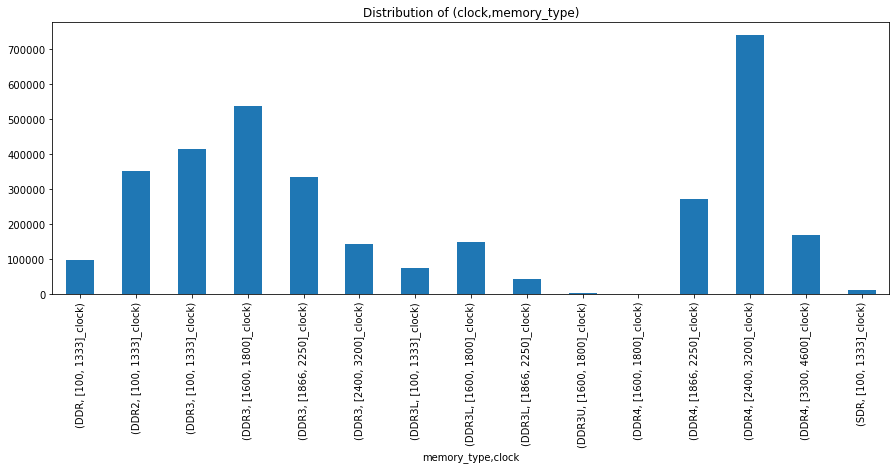

In [10]:
plt.figure(figsize=(15,5))
plt.title("Distribution of (clock,memory_type)")
df_sales_proc.groupby(["memory_type", "clock"]).size().plot(kind="bar")
plt.show()

Again we defined interval roughly based on a equal-frequency binning approach and what can be considered a low-end/high-end product.  
Note that this is only a rough approximation, for the purpouse of discretising we are ignoring the memory_type even though the distribution of the clock is not uniform across the DDR types.

#### Sales

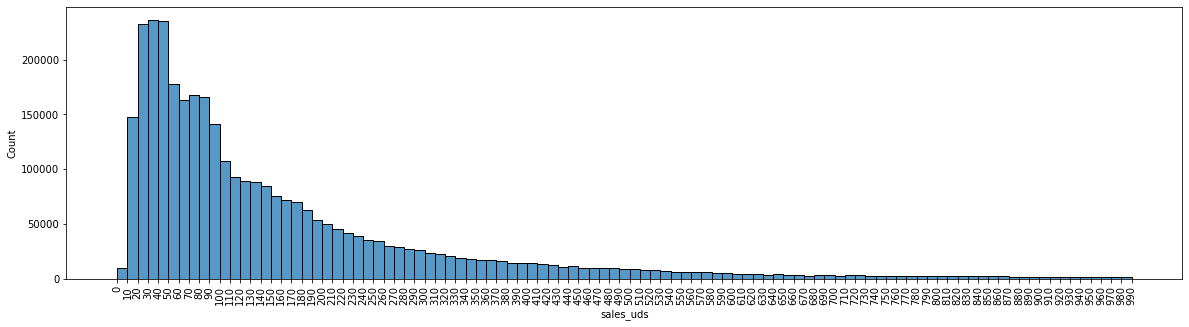

In [11]:
bins = range(0, 1000, 10)

plt.figure(figsize=(20,5))
sn.histplot(df_sales_proc["sales_uds"], bins=bins)
plt.xticks(bins, rotation=90)
plt.show()

In this case we will split the data based on the frequency of the entries using quantiles.

In [12]:
pd.qcut(df_sales_proc["sales_uds"].astype(int), 10).unique()

[(0.999, 27.0], (27.0, 41.0], (41.0, 57.0], (57.0, 78.0], (78.0, 99.0], (99.0, 134.0], (134.0, 177.0], (177.0, 246.0], (246.0, 395.0], (395.0, 10630.0]]
Categories (10, interval[float64]): [(0.999, 27.0] < (27.0, 41.0] < (41.0, 57.0] < (57.0, 78.0] ... (134.0, 177.0] < (177.0, 246.0] < (246.0, 395.0] < (395.0, 10630.0]]

In [13]:
df_sales_proc.loc[:, "sales_uds"] = pd.qcut(df_sales_proc["sales_uds"].astype(int), 10)

df_sales_proc.loc[:, "sales_uds"] = df_sales_proc["sales_uds"].astype(str) + '_sales_uds'

#### Results

In [14]:
df_sales_proc.head()

ram_code  brand   name      memory memory_type              clock  \
2602347        1  ADATA  Adata  [0, 4]_mem         DDR  [100, 1333]_clock   
2602348        1  ADATA  Adata  [0, 4]_mem         DDR  [100, 1333]_clock   
2602349        1  ADATA  Adata  [0, 4]_mem         DDR  [100, 1333]_clock   
2602350        1  ADATA  Adata  [0, 4]_mem         DDR  [100, 1333]_clock   
2602351        1  ADATA  Adata  [0, 4]_mem         DDR  [100, 1333]_clock   

         year  month  day  week continent  country                  region  \
2602347  2013      3   22    12    Europe  Germany  north rhine-westphalla   
2602348  2013      3   23    12    Europe  Germany                  berlin   
2602349  2013      3   26    13    Europe  Germany                  saxony   
2602350  2013      3   27    13    Europe  Germany  north rhine-westphalla   
2602351  2013      3   28    13    Europe  Germany                saarland   

        currency       name_vendor                sales_uds  
2602347      EUR  geizhals_unknown  (0.999, 27.0]_sales_uds  
2602348      EUR  geizhals_unknown  (0.999, 27.0]_sales_uds  
2602349      EUR  geizhals_unknown  (0.999, 27.0]_sales_uds  
2602350      EUR  geizhals_unknown  (0.999, 27.0]_sales_uds  
2602351      EUR  geizhals_unknown  (0.999, 27.0]_sales_uds

## Association rules

### Vendor-level associations
Due to memory constraints we are forced to apply a stratified (with respect to the vendor) random sampling to the sales dataset.

In [15]:
df_assoc_sampled = df_sales_proc.groupby(["name_vendor"]).sample(frac=0.001, random_state=0)
num_trans_assoc = df_assoc_sampled.shape[0]

print(f"Number of transactions sampled: {num_trans_assoc}")
df_assoc_sampled.head()

Number of transactions sampled: 3341


ram_code     brand                  name        memory memory_type  \
3528941      854   CRUCIAL               Crucial    [0, 4]_mem        DDR4   
5089507     2201  KINGSTON  Kingston Hyperx Fury    [6, 8]_mem        DDR4   
3538678      857   CRUCIAL               Crucial    [6, 8]_mem        DDR4   
3452453      804   CRUCIAL               Crucial    [6, 8]_mem        DDR3   
3556244      861   CRUCIAL               Crucial  [12, 16]_mem        DDR4   

                      clock  year  month  day  week continent  \
3528941  [1866, 2250]_clock  2017     10   22    43   Oceania   
5089507  [2400, 3200]_clock  2017      8    5    32    Europe   
3538678  [1866, 2250]_clock  2017     10    4    41   America   
3452453  [1600, 1800]_clock  2017      2    4     6   America   
3556244  [2400, 3200]_clock  2017     10   10    42   America   

                          country                  region currency  \
3528941                New Zeland   south island-southern      NZD   
5089507                   Germany  mecklenburg-vorpommern      EUR   
3538678  United States of America          north-east usa      USD   
3452453  United States of America          north-east usa      USD   
3556244  United States of America            mid-atalntic      USD   

                  name_vendor                 sales_uds  
3528941  1stWave Technologies    (41.0, 57.0]_sales_uds  
5089507                  ARLT   (99.0, 134.0]_sales_uds  
3538678               Adorama   (99.0, 134.0]_sales_uds  
3452453               Adorama    (78.0, 99.0]_sales_uds  
3556244               Adorama  (134.0, 177.0]_sales_uds

In [16]:
trans_ram_code = df_assoc_sampled.groupby(["name_vendor"])["ram_code"].apply(list)
trans_ram_code.head()

name_vendor
1stWave Technologies                                                [854]
ARLT                                                               [2201]
Adorama                                                   [857, 804, 861]
Alternate                                               [1297, 1485, 440]
Alza                    [679, 973, 2189, 3234, 2188, 2046, 857, 1601, ...
Name: ram_code, dtype: object

We defined the transactions with respect to the vendor in order to find association rules that hold for multiple vendors.  

In [17]:
baskets_ram = trans_ram_code.values
num_bask_ram = baskets_ram.shape[0]
num_bask_ram

65

In [18]:
rules_ram = fim_apriori(baskets_ram, supp=5, zmin=2, target='r', conf=60, report='ascl')
print('Number of rules:', len(rules_ram))

Number of rules: 5563


In [19]:
report_cols = ["Conseq.", "Prem.", "Support (abs)", "Support (frac)", "Confidence", "Lift"]

rules_ram_df = pd.DataFrame(rules_ram, columns=report_cols)

In [20]:
rules_ram_df.sort_values(["Support (abs)", "Lift"], ascending=False)

Conseq.    Prem.  Support (abs)  Support (frac)  Confidence      Lift
3373    1404  (1591,)              5        0.076923    0.833333  7.738095
3374    1591  (1404,)              5        0.076923    0.714286  7.738095
5553    1404   (955,)              5        0.076923    0.833333  7.738095
5554     955  (1404,)              5        0.076923    0.714286  7.738095
5561    1404   (698,)              5        0.076923    0.833333  7.738095
...      ...      ...            ...             ...         ...       ...
25      2186  (2055,)              3        0.046154    0.600000  3.900000
50      2186  (2315,)              3        0.046154    0.600000  3.900000
67      2186  (2037,)              3        0.046154    0.600000  3.900000
110     2186   (858,)              3        0.046154    0.600000  3.900000
114     2186   (860,)              3        0.046154    0.600000  3.900000

[5563 rows x 6 columns]

The support for these rules is very low, no rule goes above 7% support.

#### Features
In order to facilitate the analysis we will extract some features from both the premises and consequent.

In [21]:
def add_features_num(df):
    
    new_df = pd.DataFrame(index=df.index)
    
    for idx, row in df.iterrows():
        
        conseq_entry = df_ram.loc[int(row["Conseq."])]
        
        prem_list = [int(x) for x in row["Prem."]]
        prem_df = df_ram.loc[prem_list]
        
        new_df.loc[idx, "Conseq."] = row["Conseq."]
        new_df.loc[idx, "Num Prem."] = len(prem_list)
        
        new_df.loc[idx, "C. mem"] = int(conseq_entry["memory"])
        new_df.loc[idx, "P. min mem"] = int(prem_df["memory"].min())
        new_df.loc[idx, "P. avg mem"] = int(prem_df["memory"].mean())
        
        new_df.loc[idx, "C. brand"] = conseq_entry["brand"]
        new_df.loc[idx, "P. brand"] = str(prem_df["brand"].unique())
        
        new_df.loc[idx, "C. mem type"] = conseq_entry["memory_type"]
        new_df.loc[idx, "P. mem type"] = str(prem_df["memory_type"].unique())
        
        new_df.loc[idx, "C. clock"] = int(conseq_entry["clock"])
        new_df.loc[idx, "P. min clock"] = int(prem_df["clock"].min())
        new_df.loc[idx, "P. avg clock"] = int(prem_df["clock"].mean())
    
    new_df = new_df.join(df[["Support (abs)", "Confidence", "Lift"]])
    
    return new_df

ram_rules_feat = add_features_num(rules_ram_df)

In [22]:
ram_rules_feat.sort_values(["Lift", "Support (abs)"], ascending=False).head()

Conseq.  Num Prem.  C. mem  P. min mem  P. avg mem C. brand  \
2410     510        3.0    16.0        16.0        37.0  CORSAIR   
2413     510        2.0    16.0        16.0        40.0  CORSAIR   
3093    1431        3.0    16.0         4.0        14.0  G.SKILL   
3096    1431        2.0    16.0         4.0         6.0  G.SKILL   
3103    1431        2.0    16.0         8.0        20.0  G.SKILL   

                              P. brand C. mem type      P. mem type  C. clock  \
2410             ['G.SKILL' 'CORSAIR']        DDR4         ['DDR4']    3200.0   
2413             ['G.SKILL' 'CORSAIR']        DDR4         ['DDR4']    3200.0   
3093  ['KINGSTON' 'CRUCIAL' 'G.SKILL']        DDR3  ['DDR3' 'DDR4']    1866.0   
3096            ['KINGSTON' 'CRUCIAL']        DDR3         ['DDR3']    1866.0   
3103            ['KINGSTON' 'G.SKILL']        DDR3  ['DDR3' 'DDR4']    1866.0   

      P. min clock  P. avg clock  Support (abs)  Confidence   Lift  
2410        3200.0        3200.0              4         1.0  16.25  
2413        3200.0        3200.0              4         1.0  16.25  
3093        1600.0        2133.0              4         1.0  16.25  
3096        1600.0        1600.0              4         1.0  16.25  
3103        1600.0        2400.0              4         1.0  16.25

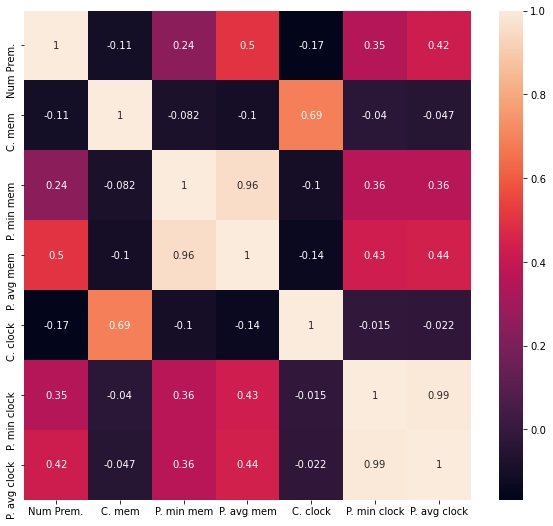

In [23]:
plt.figure(figsize=(10,9))
corr_df = ram_rules_feat.sort_values(["Lift", "Support (abs)"]).drop(["Support (abs)", "Confidence", "Lift"], axis=1).head(50)
sn.heatmap(corr_df.corr(), annot=True)
plt.show()

No correlation, this level of analysis doesn't seem fruitful.

#### Conclusions
There are no apparent relationships between the consequent and the premises of the ram modules sold.  

### Dataframe-level associations
Here we apply to the whole dataframe taking each row as its own transaction.

In [24]:
report_cols = ["Conseq.", "Prem.", "Support (abs)", "Support (frac)", "Confidence", "Lift"]

In [25]:
def filter_rules(rule_df, filter_func_list):
    
    for idx, row in rule_df.iterrows():
        
        prems = row.loc["Prem."]
        conseqs = row.loc["Conseq."]
        
        for filter_func in filter_func_list:
            if filter_func(prems, conseqs):
                
                rule_df = rule_df.drop(row.name)
                break #Already deleted, no need for further filtering
    
    return rule_df
                
                
def filter_country_continent_curr(prems, conseq):
    #Filters all associations between currency, country and continent
    
    curr_vals = df_geo["currency"].unique()
    country_vals = df_geo["country"].unique()
    contin_vals = df_geo["continent"].unique()
    
    for prem in prems:
        if prem in curr_vals:
            
            if conseq in country_vals or conseq in contin_vals:
                return True
            
        if prem in country_vals or prem in contin_vals:
            
            if conseq in curr_vals:
                return True
            
            if conseq in country_vals or conseq in contin_vals:
                return True
                    
    return False


def filter_brand_ram_name(prems, conseq):
    #Filter associations between brand and brand's product name
    
    brand_vals = df_ram["brand"].unique()
    name_vals = df_ram["name"].unique()
    
    for prem in prems:
        if prem in brand_vals and conseq in name_vals:
            return True
        if prem in name_vals and conseq in brand_vals:
            return True
        
    return False            

A significant percentage of the rules discovered are "obvious" associations, such as "the transactions in country x use the currency of that country".  
In order to filter them out we create some ad-hoc filter rules.

In [26]:
filters = [filter_country_continent_curr, filter_brand_ram_name]

baskets_whole_df = df_sales_proc.drop(["year", "month", "week", "day"], axis=1) #Remove time-related features
baskets_whole = baskets_whole_df.values.tolist()

#Keep only entries with Lift >=2
rules_whole = fim_apriori(baskets_whole, supp=5, zmin=2, target='r', conf=60, report='ascl', eval="l", thresh=200, prune=1)

rules_whole_df = pd.DataFrame(rules_whole, columns=report_cols).sort_values(["Lift", "Support (abs)"], ascending=False)
rules_whole_df_filtered = filter_rules(rules_whole_df, filters)

print('Number of rules:', rules_whole_df_filtered.shape[0])

Number of rules: 25


In order to sift through the rules more easily we used the pruning functionality of the apriori implementation.

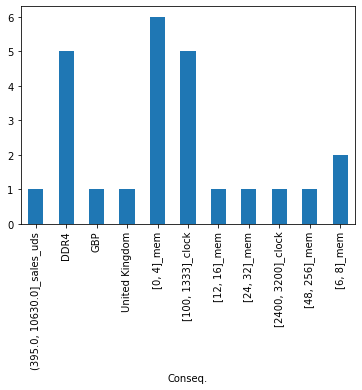

In [27]:
rules_whole_df_filtered.groupby("Conseq.").size().plot(kind="bar")
plt.show()

We will take a brief look at each consequent in order to see if there is any new information to be had.

In [28]:
rules_whole_df_filtered.loc[rules_whole_df_filtered["Conseq."] == '(395.0, 10630.0]_sales_uds'].head()

Conseq.             Prem.  Support (abs)  \
12  (395.0, 10630.0]_sales_uds  ([48, 256]_mem,)         194924   

    Support (frac)  Confidence      Lift  
12        0.058313    0.883769  8.864869

Intuitively the ram modules that have a lot of memory cost a lot.

In [29]:
rules_whole_df_filtered.loc[rules_whole_df_filtered["Conseq."] == 'DDR4'].head(10)

Conseq.                                        Prem.  Support (abs)  \
0     DDR4                        ([3300, 4600]_clock,)         167989   
35    DDR4                        ([2400, 3200]_clock,)         739904   
10    DDR4  ([48, 256]_mem, (395.0, 10630.0]_sales_uds)         145080   
13    DDR4                             ([48, 256]_mem,)         159804   
22    DDR4                ((395.0, 10630.0]_sales_uds,)         238866   

    Support (frac)  Confidence      Lift  
0         0.050255    1.000000  2.836010  
35        0.221349    0.837388  2.374840  
10        0.043402    0.744290  2.110814  
13        0.047807    0.724538  2.054796  
22        0.071459    0.716788  2.032818

Here the rules roughly point out which are the clock rates, price and memory size associated with DDR4.

In [30]:
rules_whole_df_filtered.loc[rules_whole_df_filtered["Conseq."].isin(['United Kingdom', 'GBP'])].head(10)

Conseq.                Prem.  Support (abs)  Support (frac)  \
17  United Kingdom  (pricespy_unknown,)         289464        0.086596   
18             GBP  (pricespy_unknown,)         289464        0.086596   

    Confidence      Lift  
17    0.908576  5.940088  
18    0.908576  5.940088

As we pointed out in task 1, pricespy_unknown is a UK-based price search engine so no surprises here.

In [31]:
rules_whole_df_filtered.loc[rules_whole_df_filtered["Conseq."]\
                            .isin(['[0, 4]_mem', '[6, 8]_mem', '[12, 16]_mem', '[24, 32]_mem', '[48, 256]_mem'])].head(20)

Conseq.                                         Prem.  \
11  [48, 256]_mem            ((395.0, 10630.0]_sales_uds, DDR4)   
23   [24, 32]_mem                   ((246.0, 395.0]_sales_uds,)   
24     [0, 4]_mem  ((0.999, 27.0]_sales_uds, [100, 1333]_clock)   
27     [0, 4]_mem                    ((0.999, 27.0]_sales_uds,)   
29     [0, 4]_mem                     (DDR2, [100, 1333]_clock)   
32     [0, 4]_mem                                       (DDR2,)   
20     [0, 4]_mem                     ((27.0, 41.0]_sales_uds,)   
21   [12, 16]_mem                   ((134.0, 177.0]_sales_uds,)   
28     [6, 8]_mem                     ((57.0, 78.0]_sales_uds,)   
19     [6, 8]_mem                     ((78.0, 99.0]_sales_uds,)   
37     [0, 4]_mem                          ([100, 1333]_clock,)   

    Support (abs)  Support (frac)  Confidence      Lift  
11         145080        0.043402    0.607370  9.205001  
23         212409        0.063544    0.635930  4.545196  
24         265411        0.079400    0.997463  3.420766  
27         340528        0.101872    0.996264  3.416653  
29         313826        0.093884    0.889179  3.049409  
32         313826        0.093884    0.889179  3.049409  
20         287597        0.086037    0.864496  2.964758  
21         240845        0.072051    0.723595  2.876512  
28         225192        0.067368    0.648568  2.584337  
19         204856        0.061285    0.628549  2.504566  
37         640626        0.191649    0.672841  2.307485

Here we can see the association rules between the memory size and the price/clock/memory type.  
These rules allow us (with good confidence) to estimate the amount of ram in module given its price.  
It also points out that DDR2 sales consist mostly of small memory modules.

In [32]:
rules_whole_df_filtered.loc[rules_whole_df_filtered["Conseq."].isin(['[100, 1333]_clock', '[2400, 3200]_clock'])].head(10)

Conseq.                                  Prem.  Support (abs)  \
31   [100, 1333]_clock                                (DDR2,)         352939   
30   [100, 1333]_clock                     (DDR2, [0, 4]_mem)         313826   
25   [100, 1333]_clock  ((0.999, 27.0]_sales_uds, [0, 4]_mem)         265411   
26   [100, 1333]_clock             ((0.999, 27.0]_sales_uds,)         266086   
36  [2400, 3200]_clock                                (DDR4,)         739904   
38   [100, 1333]_clock                          ([0, 4]_mem,)         640626   

    Support (frac)  Confidence      Lift  
31        0.105585    1.000000  3.510793  
30        0.093884    1.000000  3.510793  
25        0.079400    0.779410  2.736348  
26        0.079602    0.778473  2.733058  
36        0.221349    0.627749  2.374840  
38        0.191649    0.657255  2.307485

These are the associations between the clock and the other features.  
We can see that, as we pointed out in the pre-processing step, the lowest clock range is very strongly associated with low-end ram (low memory/cost).

## Frequent sequences
Here we will try to find interesting information regarding the ram sales mining frequent sequences from a database built using time/location features and containing the sales as elements.

### Time-based baskets

#### Week

In [40]:
baskets_sampled_week = df_sales_proc.reset_index().sample(frac=0.002, random_state=0)
print(f"Entries sampled: {baskets_sampled_week.shape[0]}")

Entries sampled: 6685


In [41]:
baskets_week = baskets_sampled_week.groupby(["year", "week"])["ram_code"].apply(lambda x: [[y] for y in x])
"""chosen_feat = ["ram_code", "brand", "country", "memory", "memory_type", "clock", "continent", "country", \
               "region", "currency", "name_vendor", "sales_uds"]

for i in range(baskets_week.shape[0]):
    row = baskets_week.iloc[i]
    
    for j in range(len(row)):
        baskets_week.iloc[i][j] = df_sales_proc.loc[df_sales_proc.index==row[j], "ram_code"].values
"""
baskets_week

year  week
2013  12                                               [[2432]]
      13       [[1683], [2618], [2982], [2434], [1568], [2483]]
      14       [[2778], [2131], [1644], [1486], [1470], [2772]]
      15      [[780], [1678], [2383], [2809], [1491], [2414]...
      16      [[1907], [1532], [425], [1936], [1537], [2773]...
                                    ...                        
2018  11      [[1836], [2299], [711], [1223], [975], [772], ...
      12      [[2236], [2285], [2446], [509], [2217], [1153]...
      13      [[694], [618], [843], [3581], [1340], [2045], ...
      14      [[2527], [2033], [441], [95], [1058], [797], [...
      15      [[2443], [859], [1390], [1404], [2276], [3613]...
Name: ram_code, Length: 269, dtype: object

In [162]:
format_baskets = []
for row in baskets_week.values:
    format_baskets.append(row)

ap_result = gsp_apriori(format_baskets, baskets_week.shape[0]*5//100, verbose=False)

For computational reasons we limited the search for support >= 5%.

In [177]:
result_week_df = pd.DataFrame(ap_result, columns=["Seq.", "Supp. (abs)"])

result_week_df["Supp. (frac)"] = result_week_df["Supp. (abs)"]/baskets_week.shape[0]
result_week_df["Seq. len"] = result_week_df["Seq."].apply(lambda x: len(x[0]))

result_week_df.sort_values(["Supp. (abs)", "Seq. len"], ascending=False)

Seq.  Supp. (abs)  Supp. (frac)  Seq. len
2   [[2185]]           20      0.074349         1
15   [[656]]           19      0.070632         1
20   [[804]]           18      0.066914         1
22   [[977]]           18      0.066914         1
4   [[2188]]           17      0.063197         1
5   [[2189]]           17      0.063197         1
14   [[655]]           17      0.063197         1
3   [[2186]]           16      0.059480         1
9   [[2440]]           16      0.059480         1
17   [[659]]           16      0.059480         1
21   [[975]]           16      0.059480         1
11  [[2445]]           15      0.055762         1
16   [[657]]           15      0.055762         1
6   [[2277]]           14      0.052045         1
8   [[2298]]           14      0.052045         1
18   [[660]]           14      0.052045         1
0   [[1404]]           13      0.048327         1
1   [[1591]]           13      0.048327         1
7   [[2294]]           13      0.048327         1
10  [[2442]]           13      0.048327         1
12   [[602]]           13      0.048327         1
13   [[642]]           13      0.048327         1
19   [[749]]           13      0.048327         1

We only found sequences of length one, meaning that this can be reduced to a contest of "popularity" of ram in the market on a week by week basis.

In [218]:
list_idx = []

for idx, row in result_week_df.iterrows():
    list_idx.append((row["Seq."][0][0]))
    

df_sales_proc.loc[df_sales_proc["ram_code"].isin(list_idx)].groupby("ram_code").size().describe()

count      23.000000
mean     6219.347826
std      1728.462496
min      2733.000000
25%      5018.000000
50%      6734.000000
75%      7827.000000
max      8664.000000
dtype: float64

In [219]:
df_sales_proc.groupby("ram_code").size().describe()

count    3111.000000
mean     1074.477660
std      1226.876352
min         1.000000
25%       104.000000
50%       620.000000
75%      1814.000000
max      8664.000000
dtype: float64

We can see that the number of sales for the least sold ram module in the sequences is greater than the 75% quantile value of all the other modules not included.

#### Month

In [61]:
baskets_sampled_month = df_sales_proc.reset_index().sample(frac=0.001, random_state=0)
print(f"Entries sampled: {baskets_sampled_month.shape[0]}")

Entries sampled: 3343


In [62]:
baskets_month = baskets_sampled_month.groupby(["year", "month"])["ram_code"].apply(lambda x: [[y] for y in x])
baskets_month

year  month
2013  3                         [[1683], [2618], [2982], [2434]]
      4        [[780], [2778], [1907], [1678], [2383], [2131]...
      5        [[2149], [969], [2787], [1498], [1524], [2436]...
      6        [[1571], [1704], [1043], [1423], [2455], [1912...
      7        [[1248], [1222], [581], [766], [1303], [2795],...
                                     ...                        
2017  12       [[660], [143], [442], [2239], [421], [2067], [...
2018  1        [[1333], [2384], [1163], [930], [1941], [113],...
      2        [[3425], [177], [857], [3], [182], [2218], [10...
      3        [[2236], [975], [1836], [533], [1458], [1640],...
      4        [[2527], [2033], [441], [2443], [618], [95], [...
Name: ram_code, Length: 62, dtype: object

In [78]:
format_baskets = []
for row in baskets_month.values:
    format_baskets.append(row)

ap_result = gsp_apriori(format_baskets, baskets_month.shape[0]*10//100, verbose=False)

result_month_df = pd.DataFrame(ap_result, columns=["Seq.", "Supp. (abs)"])
result_month_df["Supp. (frac)"] = result_month_df["Supp. (abs)"]/baskets_month.shape[0]
result_month_df["Seq. len"] = result_month_df["Seq."].apply(lambda x: len(x))

Always for computational reasons, in this case we analyse only rules with support >= 10%.

In [80]:
result_month_df.sort_values(["Seq. len", "Supp. (abs)"], ascending=False)

Seq.  Supp. (abs)  Supp. (frac)  Seq. len
71  [[804], [656]]            6      0.096774         2
56         [[656]]           14      0.225806         1
66         [[804]]           13      0.209677         1
58         [[659]]           11      0.177419         1
28        [[2185]]           10      0.161290         1
..             ...          ...           ...       ...
61         [[679]]            6      0.096774         1
62         [[698]]            6      0.096774         1
63         [[733]]            6      0.096774         1
64         [[749]]            6      0.096774         1
65         [[778]]            6      0.096774         1

[72 rows x 4 columns]

Here we also have a sequence of length 2.

In [223]:
month_seq_2 = df_ram.loc[[804, 656]]
month_seq_2

brand               name  memory memory_type  clock
ram_code                                                       
804       CRUCIAL            Crucial     8.0        DDR3   1600
656       CORSAIR  Corsair Vengeance    16.0        DDR4   2400

The support for this rule is not particularly high in absolute terms so this could be a fluke.  
However one possible explanation could be that these two ram modules are a particularly good deal price-wise for their respective features.  

##### Hp testing

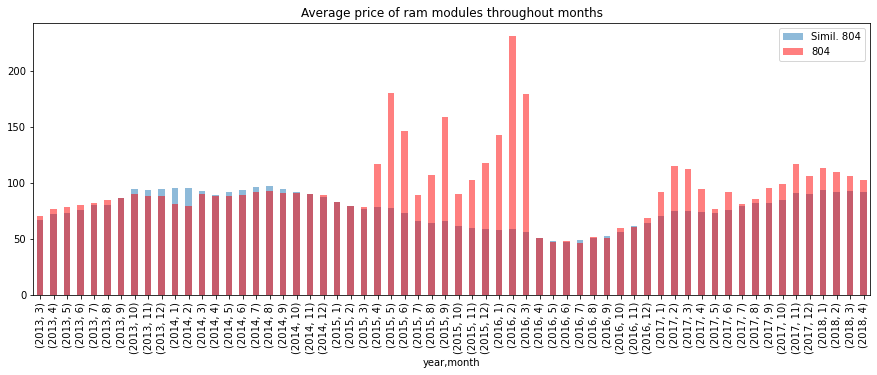

In [259]:
conditions_1 = ((df_sales_merged["memory"] == 8) & (df_sales_merged["memory_type"] == "DDR3") & (df_sales_merged["clock"] == 1600))

plt.figure(figsize=(15,5))
plt.title("Average price of ram modules throughout months")
df_sales_merged.loc[conditions_1].groupby(["year", "month"])["sales_uds"].mean().rename("Simil. 804").plot(kind="bar", alpha=0.5, )
df_sales_merged.loc[df_sales_merged["ram_code"] == "804"].groupby(["year", "month"])["sales_uds"].mean().rename("804")\
                    .plot(kind="bar", color="red", alpha=0.5)
plt.legend()
plt.show()

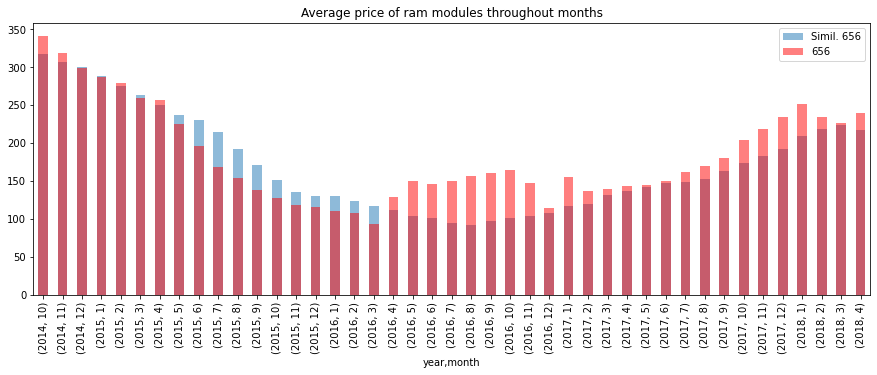

In [260]:
conditions_2 = ((df_sales_merged["memory"] == 16) & (df_sales_merged["memory_type"] == "DDR4") & (df_sales_merged["clock"] == 2400))

plt.figure(figsize=(15,5))
plt.title("Average price of ram modules throughout months")
df_sales_merged.loc[conditions_2].groupby(["year", "month"])["sales_uds"].mean().rename("Simil. 656").plot(kind="bar", alpha=0.5)
df_sales_merged.loc[df_sales_merged["ram_code"] == "656"].groupby(["year", "month"])["sales_uds"].mean().rename("656")\
                    .plot(kind="bar", color="red", alpha=0.5)
plt.legend()
plt.show()

Unfortunately the months in which the months in which the two modules are more appealing do not overlap, this invalidates the hypothesis.

#### Year

In [93]:
baskets_sampled_year = df_sales_proc.reset_index().sample(frac=0.01, random_state=0)
print(f"Entries sampled: {baskets_sampled_year.shape[0]}")

Entries sampled: 33427


In [94]:
baskets_year = baskets_sampled_year.groupby(["year"])["ram_code"].apply(lambda x: [[y] for y in x])
baskets_year

year
2013    [[986], [2526], [738], [1040], [1248], [1571],...
2014    [[912], [2122], [997], [552], [3374], [1058], ...
2015    [[1642], [1253], [966], [961], [2741], [1877],...
2016    [[946], [515], [990], [1405], [3669], [588], [...
2017    [[2427], [446], [1591], [1575], [2517], [2476]...
2018    [[1333], [2236], [975], [1836], [3425], [533],...
Name: ram_code, dtype: object

In [99]:
format_baskets = []
for row in baskets_year.values:
    format_baskets.append(row)

ap_result = gsp_apriori(format_baskets, baskets_sampled_year.shape[0]*5//100, verbose=False)

result_year_df = pd.DataFrame(ap_result, columns=["Seq.", "Supp. (abs)"])
result_year_df["Supp. (frac)"] = result_year_df["Supp. (abs)"]/baskets_year.shape[0]
result_year_df["Seq. len"] = result_year_df["Seq."].apply(lambda x: len(x))

In [98]:
result_year_df.sort_values(["Seq. len", "Supp. (abs)"], ascending=False)

Empty DataFrame
Columns: [Seq., Supp. (abs), Supp. (frac), Seq. len]
Index: []

There are no rules with at least a 5% support.

### Location-based baskets

#### Region

In [155]:
baskets_sampled_region = df_sales_proc.reset_index().sample(frac=0.0005, random_state=0)
print(f"Entries sampled: {baskets_sampled_region.shape[0]}")

Entries sampled: 1671


In [156]:
baskets_region = baskets_sampled_region.groupby(["region"])["ram_code"].apply(lambda x: [[y] for y in x])
baskets_region

region
analucia              [[2517], [961], [2531], [1588], [1303], [678],...
aragon                                                         [[1425]]
atlantic provinces                                             [[1390]]
baden-wuttemberg      [[1383], [2308], [2038], [2217], [1580], [2046...
bavaria               [[1419], [1836], [1365], [2183], [1649], [1177...
                                            ...                        
wallonia                                                       [[1153]]
west midlands         [[2384], [54], [1247], [642], [2185], [2445], ...
west usa              [[482], [1397], [2033], [707], [2182], [622], ...
western australia                                 [[444], [676], [626]]
yorkshire             [[3543], [679], [1566], [2320], [2969], [2271]...
Name: ram_code, Length: 69, dtype: object

In [263]:
format_baskets = []
for row in baskets_region.values:
    format_baskets.append(row)

ap_result = gsp_apriori(format_baskets, baskets_region.shape[0]*5//100, verbose=False)

result_region_df = pd.DataFrame(ap_result, columns=["Seq.", "Supp. (abs)"])
result_region_df["Supp. (frac)"] = result_region_df["Supp. (abs)"]/baskets_region.shape[0]
result_region_df["Seq. len"] = result_region_df["Seq."].apply(lambda x: len(x))

For computational reasons we limited the search for support >= 5%.

In [265]:
result_region_df.sort_values(["Seq. len", "Supp. (abs)"], ascending=False).head(10)

Seq.  Supp. (abs)  Supp. (frac)  Seq. len
140  [[1360], [1232]]            3      0.043478         2
141   [[147], [1907]]            3      0.043478         2
142  [[1571], [1399]]            3      0.043478         2
143  [[1907], [2400]]            3      0.043478         2
144   [[2185], [147]]            3      0.043478         2
145   [[2440], [977]]            3      0.043478         2
146   [[552], [1907]]            3      0.043478         2
147   [[589], [1248]]            3      0.043478         2
148    [[973], [867]]            3      0.043478         2
60           [[2185]]            8      0.115942         1

The support is very low for these length 2 sequences.

In [301]:
region_seq_2 = pd.DataFrame(columns=df_ram.columns)

for idx, row in result_region_df.loc[result_region_df["Seq. len"] == 2].iterrows():
    
    list_idx = [int(x[0]) for x in row["Seq."]]
    region_seq_2 = region_seq_2.append(df_ram.loc[list_idx])
    
region_seq_2

brand                     name  memory memory_type clock
1360   G.SKILL        G.Skill Ripjaws 4    16.0        DDR4  2666
1232   G.SKILL               G.Skill Ns     4.0        DDR3  1333
147      ADATA           Adata Xpg V1.0    16.0        DDR3  1866
1907   GOODRAM                  Goodram     2.0        DDR3  1600
1571   G.SKILL        G.Skill Trident X    32.0        DDR3  2400
1399   G.SKILL        G.Skill Ripjaws V    32.0        DDR4  2133
1907   GOODRAM                  Goodram     2.0        DDR3  1600
2400  KINGSTON        Kingston Valueram     6.0        DDR3  1333
2185  KINGSTON     Kingston Hyperx Fury     8.0        DDR3  1600
147      ADATA           Adata Xpg V1.0    16.0        DDR3  1866
2440  KINGSTON        Kingston Valueram     4.0        DDR4  2133
977    CRUCIAL  Crucial Ballistix Sport    16.0        DDR4  2400
552    CORSAIR       Corsair Mac Memory    16.0        DDR3  1333
1907   GOODRAM                  Goodram     2.0        DDR3  1600
589    CORSAIR     Corsair Value Select     8.0       DDR3L  1333
1248   G.SKILL               G.Skill Nt     4.0        DDR2   800
973    CRUCIAL  Crucial Ballistix Sport     4.0        DDR4  2400
867    CRUCIAL                  Crucial    64.0        DDR4  2133

There is no apparent explanation for these sequence values.  
Interesting to note that some of these modules are duplicated:

In [303]:
region_seq_2.loc[region_seq_2.duplicated()]

brand            name  memory memory_type clock
1907  GOODRAM         Goodram     2.0        DDR3  1600
147     ADATA  Adata Xpg V1.0    16.0        DDR3  1866
1907  GOODRAM         Goodram     2.0        DDR3  1600

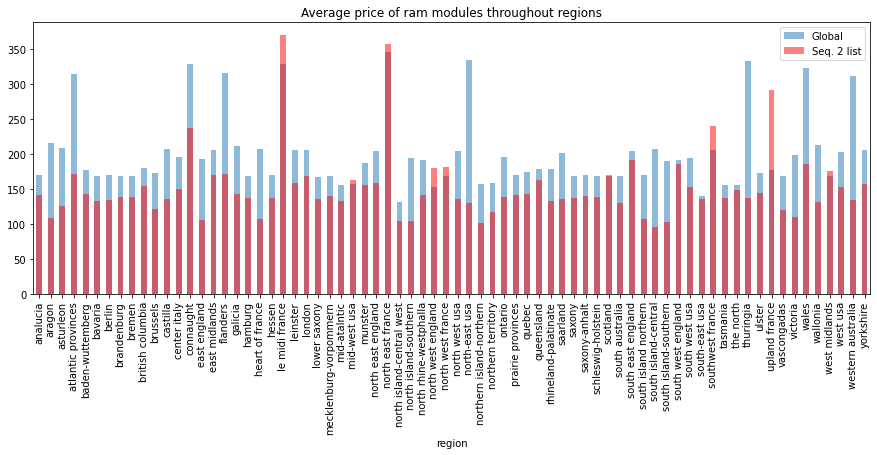

In [317]:
region_seq_2_idx = [str(x) for x in region_seq_2.drop_duplicates().index]

plt.figure(figsize=(15,5))
plt.title("Average price of ram modules throughout regions")
df_sales_merged.groupby(["region"])["sales_uds"].mean().rename("Global").plot(kind="bar", alpha=0.5)
df_sales_merged.loc[df_sales_merged["ram_code"].isin(region_seq_2_idx)].groupby(["region"])["sales_uds"].mean().rename("Seq. 2 list")\
                    .plot(kind="bar", color="red", alpha=0.5)
plt.legend()
plt.show()

#### Country/Continent grouping
We skipped this grouping due to the time required to execute the apriori algorithm on any decent sample size.

### Location/time baskets